In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import train_and_test_model
from train_and_test_model import trainModel,testModel,attention_map
from torchvision.transforms import TrivialAugmentWide,AutoAugment, AutoAugmentPolicy
from ResNet_Classifier import classifierTrain

## Load Dataset

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# transform_aug = transforms.Compose([
#     AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# transform_aug = transforms.Compose([
#     transforms.Resize(256),
#     transforms.RandomResizedCrop(224),
#     #transforms.RandomHorizontalFlip(p=0.5),
#     #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.Normalize(mean, std)
# ])

In [3]:
train_dataset_origin = datasets.ImageFolder(root='./datasets/train', transform=transform)
train_loader_origin = DataLoader(train_dataset_origin, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

test_dataset_origin = datasets.ImageFolder(root='./datasets/test', transform=transform)
test_loader_origin = DataLoader(test_dataset_origin, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

val_dataset_origin = datasets.ImageFolder(root='./datasets/val', transform=transform)
val_loader_origin = DataLoader(val_dataset_origin, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_dataset_aug = datasets.ImageFolder(root='./datasets/train', transform=transform_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

val_dataset_aug = datasets.ImageFolder(root='./datasets/val', transform=transform_aug)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

perturbation_l1 = datasets.ImageFolder(root='./datasets_l1', transform=transform)
test_loader_l1 = DataLoader(perturbation_l1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

perturbation_l2 = datasets.ImageFolder(root='./datasets_l2', transform=transform)
test_loader_l2 = DataLoader(perturbation_l2, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

perturbation_l3 = datasets.ImageFolder(root='./datasets_l3', transform=transform)
test_loader_l3 = DataLoader(perturbation_l3, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

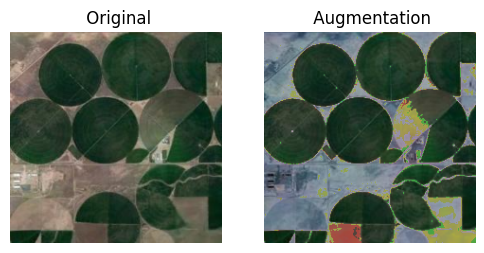

In [4]:
def show_augmented_image(ori, aug, index=0):
    img_ori, label_ori = ori[index]
    img_aug, label_aug = aug[index]
    img_ori = img_ori.permute(1, 2, 0)  # CHW -> HWC
    img_aug = img_aug.permute(1, 2, 0)  # CHW -> HWC
    img_ori = img_ori * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # unnormalize
    img_aug = img_aug * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # unnormalize
    img_ori = img_ori.clip(0, 1)
    img_aug = img_aug.clip(0, 1)
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,1)
    plt.imshow(img_ori)
    plt.title(f" Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img_aug)
    plt.title(f" Augmentation")
    plt.axis('off')
    plt.show()

show_augmented_image(train_dataset_origin, train_dataset_aug, 10)

## Fine-tuning Test

### Summary
- ResNet18 origin_acc: 91.06% aug_acc: 92.22%
- ResNet50 origin_acc: 93.17% aug_acc: 93.78%
- ResNet101 origin_acc: 92.44% aug_acc: 93.33%

### ResNet18 + LongTail Experiment/ Data Augmentation

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: can't find bestweight!
📚 Epoch 0/100
✅ Train Loss: 1.0870 | Acc: 0.7161
🧪 Val Loss: 0.5222 | Acc: 0.8644
📚 Epoch 1/100
✅ Train Loss: 0.4943 | Acc: 0.8625
🧪 Val Loss: 0.3893 | Acc: 0.8844
📚 Epoch 2/100
✅ Train Loss: 0.3922 | Acc: 0.8855
🧪 Val Loss: 0.3332 | Acc: 0.8900
📚 Epoch 3/100
✅ Train Loss: 0.3525 | Acc: 0.8954
🧪 Val Loss: 0.3156 | Acc: 0.8989
📚 Epoch 4/100
✅ Train Loss: 0.3176 | Acc: 0.9010
🧪 Val Loss: 0.2953 | Acc: 0.9067
📚 Epoch 5/100
✅ Train Loss: 0.2922 | Acc: 0.9098
🧪 Val Loss: 0.2834 | Acc: 0.9122
📚 Epoch 6/100
✅ Train Loss: 0.2802 | Acc: 0.9142
🧪 Val Loss: 0.2725 | Acc: 0.9183
📚 Epoch 7/100
✅ Train Loss: 0.2631 | Acc: 0.9160
🧪 Val Loss: 0.2721 | Acc: 0.9122
📚 Epoch 8/100
✅ Train Loss: 0.2513 | Acc: 0.9192
🧪 Val Loss: 0.2755 | Acc: 0.9111
📚 Epoch 9/100
✅ Train Loss: 0.2365 | Acc: 0.9237
🧪 Val Loss: 0.2824 | Acc: 0.9056
📚 Epoch 10/100
✅ Train Loss: 0.2325 | Acc: 0.9257
🧪 Val Loss: 0.2618 | Acc: 0.9133
📚 Epoch 11/100
✅ Train Loss: 0.2195 | Acc: 0.9277
🧪 Val Loss: 0.266

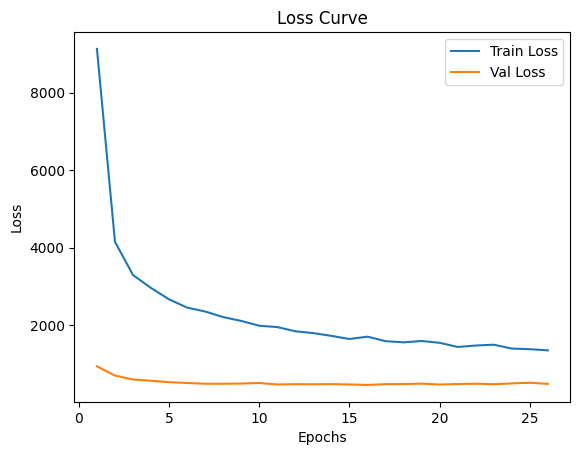

/root/CV/train_and_test_model.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestweight = torch.load(bestweight_path)


✅ ResNet-18, Accuracy: 91.06%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9055    0.9583    0.9312       120
           1     0.8909    0.8167    0.8522       120
           2     0.9640    0.8917    0.9264       120
           3     0.8143    0.9500    0.8769       120
           4     0.9597    0.9917    0.9754       120
           5     0.9576    0.9417    0.9496       120
           6     0.9008    0.9083    0.9046       120
           7     0.9008    0.9083    0.9046       120
           8     0.8492    0.8917    0.8699       120
           9     0.9426    0.9583    0.9504       120
          10     0.9910    0.9167    0.9524       120
          11     0.9182    0.8417    0.8783       120
          12     0.8583    0.8583    0.8583       120
          13     0.9914    0.9583    0.9746       120
          14     0.8455    0.8667    0.8560       120

    accuracy                         0.9106      1800
   macro avg     0.9127 

In [19]:
trainModel(18,train_loader_origin,val_loader_origin,'origin')
testModel(18,test_loader_origin,'origin')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: can't find bestweight!
📚 Epoch 0/100
✅ Train Loss: 1.3274 | Acc: 0.6271
🧪 Val Loss: 0.7540 | Acc: 0.7906
📚 Epoch 1/100
✅ Train Loss: 0.7341 | Acc: 0.7874
🧪 Val Loss: 0.6100 | Acc: 0.8122
📚 Epoch 2/100
✅ Train Loss: 0.6158 | Acc: 0.8189
🧪 Val Loss: 0.5388 | Acc: 0.8294
📚 Epoch 3/100
✅ Train Loss: 0.5533 | Acc: 0.8296
🧪 Val Loss: 0.5026 | Acc: 0.8461
📚 Epoch 4/100
✅ Train Loss: 0.5519 | Acc: 0.8231
🧪 Val Loss: 0.4750 | Acc: 0.8472
📚 Epoch 5/100
✅ Train Loss: 0.5048 | Acc: 0.8393
🧪 Val Loss: 0.4998 | Acc: 0.8406
📚 Epoch 6/100
✅ Train Loss: 0.4919 | Acc: 0.8464
🧪 Val Loss: 0.4397 | Acc: 0.8594
📚 Epoch 7/100
✅ Train Loss: 0.4876 | Acc: 0.8419
🧪 Val Loss: 0.4575 | Acc: 0.8461
📚 Epoch 8/100
✅ Train Loss: 0.4761 | Acc: 0.8457
🧪 Val Loss: 0.4531 | Acc: 0.8556
📚 Epoch 9/100
✅ Train Loss: 0.4643 | Acc: 0.8487
🧪 Val Loss: 0.4486 | Acc: 0.8522
📚 Epoch 10/100
✅ Train Loss: 0.4447 | Acc: 0.8567
🧪 Val Loss: 0.4234 | Acc: 0.8689
📚 Epoch 11/100
✅ Train Loss: 0.4492 | Acc: 0.8500
🧪 Val Loss: 0.416

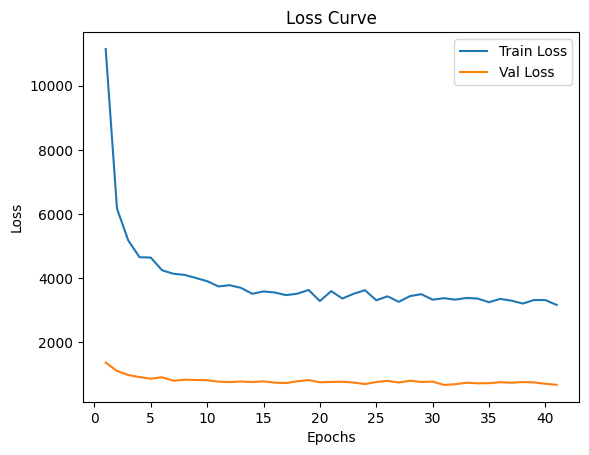

/root/CV/train_and_test_model.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestweight = torch.load(bestweight_path)


✅ ResNet-18, Accuracy: 92.22%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9344    0.9500    0.9421       120
           1     0.9143    0.8000    0.8533       120
           2     0.9106    0.9333    0.9218       120
           3     0.8672    0.9250    0.8952       120
           4     0.9675    0.9917    0.9794       120
           5     0.9649    0.9167    0.9402       120
           6     0.9040    0.9417    0.9224       120
           7     0.8889    0.9333    0.9106       120
           8     0.9545    0.8750    0.9130       120
           9     0.9200    0.9583    0.9388       120
          10     0.9910    0.9167    0.9524       120
          11     0.8889    0.9333    0.9106       120
          12     0.8934    0.9083    0.9008       120
          13     0.9280    0.9667    0.9469       120
          14     0.9217    0.8833    0.9021       120

    accuracy                         0.9222      1800
   macro avg     0.9233 

In [77]:
trainModel(18,train_loader_aug,val_loader_aug,'aug')
testModel(18,test_loader_origin,'aug')

### ResNet50 + LongTail Experiment/ Data Augmentation

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: can't find bestweight!
📚 Epoch 0/100
✅ Train Loss: 0.8143 | Acc: 0.7760
🧪 Val Loss: 0.3775 | Acc: 0.8956
📚 Epoch 1/100
✅ Train Loss: 0.3709 | Acc: 0.8880
🧪 Val Loss: 0.3140 | Acc: 0.9028
📚 Epoch 2/100
✅ Train Loss: 0.3103 | Acc: 0.8988
🧪 Val Loss: 0.2899 | Acc: 0.9061
📚 Epoch 3/100
✅ Train Loss: 0.2670 | Acc: 0.9169
🧪 Val Loss: 0.2907 | Acc: 0.9011
📚 Epoch 4/100
✅ Train Loss: 0.2550 | Acc: 0.9186
🧪 Val Loss: 0.2594 | Acc: 0.9117
📚 Epoch 5/100
✅ Train Loss: 0.2282 | Acc: 0.9270
🧪 Val Loss: 0.2563 | Acc: 0.9161
📚 Epoch 6/100
✅ Train Loss: 0.2204 | Acc: 0.9280
🧪 Val Loss: 0.2824 | Acc: 0.8978
📚 Epoch 7/100
✅ Train Loss: 0.1900 | Acc: 0.9385
🧪 Val Loss: 0.2500 | Acc: 0.9133
📚 Epoch 8/100
✅ Train Loss: 0.1807 | Acc: 0.9393
🧪 Val Loss: 0.2562 | Acc: 0.9111
📚 Epoch 9/100
✅ Train Loss: 0.1801 | Acc: 0.9385
🧪 Val Loss: 0.2689 | Acc: 0.9100
📚 Epoch 10/100
✅ Train Loss: 0.1752 | Acc: 0.9388
🧪 Val Loss: 0.2505 | Acc: 0.9172
📚 Epoch 11/100
✅ Train Loss: 0.1706 | Acc: 0.9407
🧪 Val Loss: 0.268

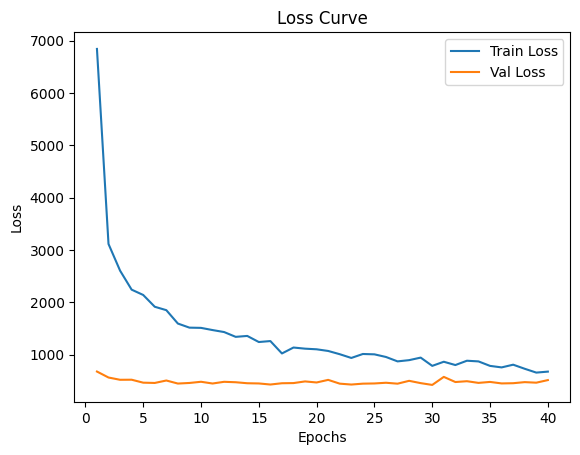

/root/CV/train_and_test_model.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestweight = torch.load(bestweight_path)


✅ ResNet-50, Accuracy: 93.17%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9008    0.9833    0.9402       120
           1     0.8871    0.9167    0.9016       120
           2     0.9504    0.9583    0.9544       120
           3     0.9818    0.9000    0.9391       120
           4     1.0000    0.9750    0.9873       120
           5     0.9360    0.9750    0.9551       120
           6     0.9720    0.8667    0.9163       120
           7     0.9714    0.8500    0.9067       120
           8     0.8102    0.9250    0.8638       120
           9     0.9355    0.9667    0.9508       120
          10     0.9590    0.9750    0.9669       120
          11     0.9344    0.9500    0.9421       120
          12     0.8880    0.9250    0.9061       120
          13     0.9831    0.9667    0.9748       120
          14     0.9018    0.8417    0.8707       120

    accuracy                         0.9317      1800
   macro avg     0.9341 

In [20]:
trainModel(50,train_loader_origin,val_loader_origin,'origin')
testModel(50,test_loader_origin,'origin')

In [81]:
trainModel(50,train_loader_aug,val_loader_aug,'aug')
testModel(50,test_loader_origin,'aug')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/CV/train_and_test_model.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

✅ ResNet-50, Accuracy: 93.78%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9741    0.9417    0.9576       120
           1     0.9098    0.9250    0.9174       120
           2     0.9817    0.8917    0.9345       120
           3     0.9911    0.9250    0.9569       120
           4     0.9831    0.9667    0.9748       120
           5     0.9744    0.9500    0.9620       120
           6     0.9350    0.9583    0.9465       120
           7     0.9417    0.9417    0.9417       120
           8     0.8640    0.9000    0.8816       120
           9     0.9070    0.9750    0.9398       120
          10     1.0000    0.9500    0.9744       120
          11     0.9127    0.9583    0.9350       120
          12     0.8672    0.9250    0.8952       120
          13     0.9669    0.9750    0.9710       120
          14     0.8833    0.8833    0.8833       120

    accuracy                         0.9378      1800
   macro avg     0.9395 

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/CV/train_and_test_model.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

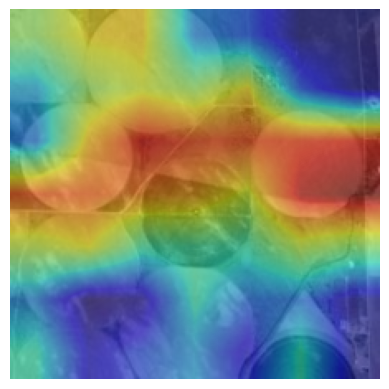

array([[0.5269015 , 0.5269015 , 0.5269015 , ..., 0.        , 0.        ,
        0.        ],
       [0.5269015 , 0.5269015 , 0.5269015 , ..., 0.        , 0.        ,
        0.        ],
       [0.5269015 , 0.5269015 , 0.5269015 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3954368 , 0.3954368 , 0.3954368 , ..., 0.03088913, 0.03088913,
        0.03088913],
       [0.3954368 , 0.3954368 , 0.3954368 , ..., 0.03088913, 0.03088913,
        0.03088913],
       [0.3954368 , 0.3954368 , 0.3954368 , ..., 0.03088913, 0.03088913,
        0.03088913]], shape=(224, 224), dtype=float32)

In [4]:
attention_map(50,test_loader_origin,'aug')

### ResNet101 + LongTail Experiment/ Data Augmentation

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: can't find bestweight!
📚 Epoch 0/100
✅ Train Loss: 0.7608 | Acc: 0.7920
🧪 Val Loss: 0.3917 | Acc: 0.8750
📚 Epoch 1/100
✅ Train Loss: 0.3651 | Acc: 0.8877
🧪 Val Loss: 0.3485 | Acc: 0.8856
📚 Epoch 2/100
✅ Train Loss: 0.3101 | Acc: 0.9039
🧪 Val Loss: 0.3109 | Acc: 0.9011
📚 Epoch 3/100
✅ Train Loss: 0.2703 | Acc: 0.9119
🧪 Val Loss: 0.2864 | Acc: 0.9050
📚 Epoch 4/100
✅ Train Loss: 0.2485 | Acc: 0.9148
🧪 Val Loss: 0.2824 | Acc: 0.9094
📚 Epoch 5/100
✅ Train Loss: 0.2195 | Acc: 0.9293
🧪 Val Loss: 0.3072 | Acc: 0.9006
📚 Epoch 6/100
✅ Train Loss: 0.2186 | Acc: 0.9255
🧪 Val Loss: 0.2724 | Acc: 0.9128
📚 Epoch 7/100
✅ Train Loss: 0.2048 | Acc: 0.9311
🧪 Val Loss: 0.2635 | Acc: 0.9161
📚 Epoch 8/100
✅ Train Loss: 0.1892 | Acc: 0.9381
🧪 Val Loss: 0.2617 | Acc: 0.9161
📚 Epoch 9/100
✅ Train Loss: 0.1769 | Acc: 0.9398
🧪 Val Loss: 0.2422 | Acc: 0.9244
📚 Epoch 10/100
✅ Train Loss: 0.1667 | Acc: 0.9442
🧪 Val Loss: 0.2777 | Acc: 0.9117
📚 Epoch 11/100
✅ Train Loss: 0.1668 | Acc: 0.9436
🧪 Val Loss: 0.272

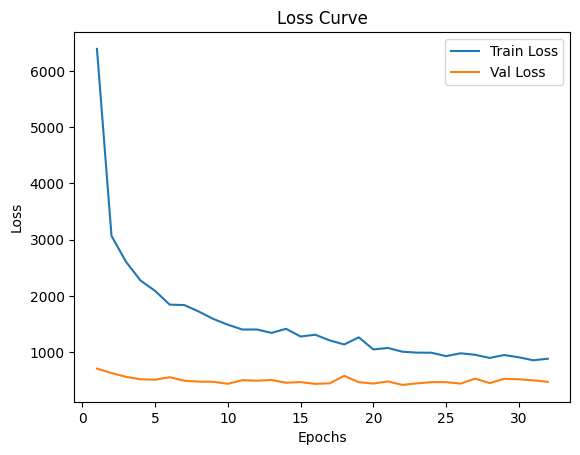

/root/CV/train_and_test_model.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestweight = torch.load(bestweight_path)


✅ ResNet-101, Accuracy: 92.44%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9823    0.9250    0.9528       120
           1     0.9204    0.8667    0.8927       120
           2     0.9727    0.8917    0.9304       120
           3     0.9630    0.8667    0.9123       120
           4     0.9754    0.9917    0.9835       120
           5     0.9508    0.9667    0.9587       120
           6     0.9407    0.9250    0.9328       120
           7     0.9545    0.8750    0.9130       120
           8     0.8370    0.9417    0.8863       120
           9     0.9832    0.9750    0.9791       120
          10     0.8939    0.9833    0.9365       120
          11     0.9717    0.8583    0.9115       120
          12     0.8385    0.9083    0.8720       120
          13     0.9206    0.9667    0.9431       120
          14     0.8162    0.9250    0.8672       120

    accuracy                         0.9244      1800
   macro avg     0.9281

In [21]:
trainModel(101,train_loader_origin,val_loader_origin,'origin')
testModel(101,test_loader_origin,'origin')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: can't find bestweight!
📚 Epoch 0/100
✅ Train Loss: 0.9799 | Acc: 0.7194
🧪 Val Loss: 0.5765 | Acc: 0.8178
📚 Epoch 1/100
✅ Train Loss: 0.5689 | Acc: 0.8225
🧪 Val Loss: 0.5053 | Acc: 0.8361
📚 Epoch 2/100
✅ Train Loss: 0.5133 | Acc: 0.8327
🧪 Val Loss: 0.4700 | Acc: 0.8533
📚 Epoch 3/100
✅ Train Loss: 0.4664 | Acc: 0.8493
🧪 Val Loss: 0.4200 | Acc: 0.8644
📚 Epoch 4/100
✅ Train Loss: 0.4345 | Acc: 0.8582
🧪 Val Loss: 0.4692 | Acc: 0.8544
📚 Epoch 5/100
✅ Train Loss: 0.4341 | Acc: 0.8570
🧪 Val Loss: 0.4157 | Acc: 0.8667
📚 Epoch 6/100
✅ Train Loss: 0.4139 | Acc: 0.8658
🧪 Val Loss: 0.4324 | Acc: 0.8644
📚 Epoch 7/100
✅ Train Loss: 0.3900 | Acc: 0.8755
🧪 Val Loss: 0.3925 | Acc: 0.8722
📚 Epoch 8/100
✅ Train Loss: 0.3951 | Acc: 0.8714
🧪 Val Loss: 0.4115 | Acc: 0.8672
📚 Epoch 9/100
✅ Train Loss: 0.3810 | Acc: 0.8748
🧪 Val Loss: 0.4859 | Acc: 0.8506
📚 Epoch 10/100
✅ Train Loss: 0.3857 | Acc: 0.8745
🧪 Val Loss: 0.3917 | Acc: 0.8839
📚 Epoch 11/100
✅ Train Loss: 0.3815 | Acc: 0.8779
🧪 Val Loss: 0.388

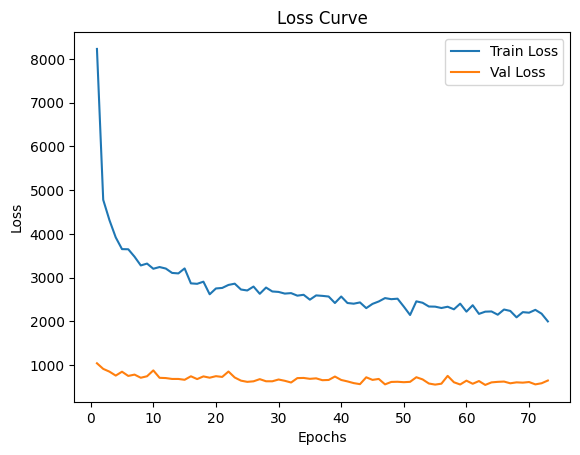

/root/CV/train_and_test_model.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestweight = torch.load(bestweight_path)


✅ ResNet-101, Accuracy: 93.33%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9268    0.9500    0.9383       120
           1     0.9537    0.8583    0.9035       120
           2     0.9587    0.9667    0.9627       120
           3     0.9550    0.8833    0.9177       120
           4     0.9677    1.0000    0.9836       120
           5     0.9134    0.9667    0.9393       120
           6     0.9206    0.9667    0.9431       120
           7     0.9727    0.8917    0.9304       120
           8     0.9813    0.8750    0.9251       120
           9     0.9496    0.9417    0.9456       120
          10     0.9590    0.9750    0.9669       120
          11     0.9350    0.9583    0.9465       120
          12     0.7770    0.9583    0.8582       120
          13     0.9587    0.9667    0.9627       120
          14     0.9182    0.8417    0.8783       120

    accuracy                         0.9333      1800
   macro avg     0.9365

In [78]:
trainModel(101,train_loader_aug,val_loader_aug,'aug')
testModel(101,test_loader_origin,'aug')

## SVM Classfier

### Summary
- ResNet18 origin_acc: 94.16%
- ResNet50 origin_acc: 96.11%
- ResNet101 origin_acc: 94.66%

Data perturbation on ResNet50 + SVM
- L1: 93.44%
- L2: 83.33%
- L3: 59.61%

Different Classifier on ResNet50:
- SVM: 96.11%
- KNN: 88.33%
- MLP: 94.77%
- Proto: 81.2%

In [33]:
classifierTrain(18,train_loader_origin,test_loader_origin,'SVM')

ResNet18 SVM Test Accuracy:0.9416666666666667

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9426    0.9583    0.9504       120
           1     0.8661    0.9167    0.8907       120
           2     0.9504    0.9583    0.9544       120
           3     0.9310    0.9000    0.9153       120
           4     1.0000    0.9750    0.9873       120
           5     0.9914    0.9583    0.9746       120
           6     0.9669    0.9750    0.9710       120
           7     0.9328    0.9250    0.9289       120
           8     0.9322    0.9167    0.9244       120
           9     0.9508    0.9667    0.9587       120
          10     0.9915    0.9667    0.9789       120
          11     0.9496    0.9417    0.9456       120
          12     0.8760    0.8833    0.8797       120
          13     0.9667    0.9667    0.9667       120
          14     0.8871    0.9167    0.9016       120

    accuracy                         0.9417      1800
   macro

In [84]:
classifierTrain(50,train_loader_origin,test_loader_origin,'SVM')

ResNet50 SVM Test Accuracy:0.9611111111111111

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.9667    0.9667       120
           1     0.9487    0.9250    0.9367       120
           2     0.9915    0.9667    0.9789       120
           3     0.9667    0.9667    0.9667       120
           4     0.9833    0.9833    0.9833       120
           5     0.9600    1.0000    0.9796       120
           6     0.9744    0.9500    0.9620       120
           7     0.9658    0.9417    0.9536       120
           8     0.9339    0.9417    0.9378       120
           9     0.9750    0.9750    0.9750       120
          10     0.9831    0.9667    0.9748       120
          11     0.9590    0.9750    0.9669       120
          12     0.9256    0.9333    0.9295       120
          13     0.9752    0.9833    0.9793       120
          14     0.9113    0.9417    0.9262       120

    accuracy                         0.9611      1800
   macro

In [4]:
# data pertubation level1
classifierTrain(50,train_loader_origin,test_loader_l1,'SVM')

ResNet50 SVM Test Accuracy:0.9344444444444444

 Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9750    0.9360       120
           1     0.8828    0.9417    0.9113       120
           2     0.9667    0.9667    0.9667       120
           3     0.9091    0.9167    0.9129       120
           4     0.9667    0.9667    0.9667       120
           5     0.9652    0.9250    0.9447       120
           6     0.9062    0.9667    0.9355       120
           7     0.9492    0.9333    0.9412       120
           8     0.8880    0.9250    0.9061       120
           9     0.9825    0.9333    0.9573       120
          10     0.9661    0.9500    0.9580       120
          11     0.9280    0.9667    0.9469       120
          12     0.9352    0.8417    0.8860       120
          13     0.9823    0.9250    0.9528       120
          14     0.9060    0.8833    0.8945       120

    accuracy                         0.9344      1800
   macro 

In [5]:
# data pertubation level2
classifierTrain(50,train_loader_origin,test_loader_l2,'SVM')

ResNet50 SVM Test Accuracy:0.8333333333333334

 Classification Report:
              precision    recall  f1-score   support

           0     0.6354    0.9583    0.7641       120
           1     0.7162    0.8833    0.7910       120
           2     0.9565    0.7333    0.8302       120
           3     0.8938    0.8417    0.8670       120
           4     0.8919    0.8250    0.8571       120
           5     0.9091    0.7500    0.8219       120
           6     0.7208    0.9250    0.8102       120
           7     0.9231    0.8000    0.8571       120
           8     0.7746    0.9167    0.8397       120
           9     0.9670    0.7333    0.8341       120
          10     0.8607    0.8750    0.8678       120
          11     0.8074    0.9083    0.8549       120
          12     0.8796    0.7917    0.8333       120
          13     0.9794    0.7917    0.8756       120
          14     0.8932    0.7667    0.8251       120

    accuracy                         0.8333      1800
   macro 

In [6]:
# data pertubation level3
classifierTrain(50,train_loader_origin,test_loader_l3,'SVM')

ResNet50 SVM Test Accuracy:0.5961111111111111

 Classification Report:
              precision    recall  f1-score   support

           0     0.3416    0.9167    0.4977       120
           1     0.4947    0.7833    0.6065       120
           2     0.9756    0.3333    0.4969       120
           3     0.7353    0.6250    0.6757       120
           4     0.6875    0.3667    0.4783       120
           5     0.7681    0.4417    0.5608       120
           6     0.5071    0.5917    0.5462       120
           7     0.8642    0.5833    0.6965       120
           8     0.4319    0.9250    0.5889       120
           9     0.8409    0.3083    0.4512       120
          10     0.6596    0.7750    0.7126       120
          11     0.6667    0.8500    0.7473       120
          12     0.8033    0.4083    0.5414       120
          13     0.9825    0.4667    0.6328       120
          14     0.8718    0.5667    0.6869       120

    accuracy                         0.5961      1800
   macro 

In [4]:
classifierTrain(50,train_loader_origin,test_loader_origin,'KNN')

ResNet50 KNN Test Accuracy:0.8833333333333333

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8819    0.9333    0.9069       120
           1     0.7500    0.7500    0.7500       120
           2     0.9478    0.9083    0.9277       120
           3     0.8983    0.8833    0.8908       120
           4     0.9304    0.8917    0.9106       120
           5     0.9355    0.9667    0.9508       120
           6     0.8770    0.8917    0.8843       120
           7     0.9533    0.8500    0.8987       120
           8     0.8772    0.8333    0.8547       120
           9     0.8889    0.9333    0.9106       120
          10     0.9256    0.9333    0.9295       120
          11     0.9130    0.8750    0.8936       120
          12     0.7410    0.8583    0.7954       120
          13     0.9274    0.9583    0.9426       120
          14     0.8319    0.7833    0.8069       120

    accuracy                         0.8833      1800
   macro

In [8]:
classifierTrain(50,train_loader_origin,test_loader_origin,'MLP')

/root/CV/ResNet_Classifier.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(train_features, dtype=torch.float32).to(device)
/root/CV/ResNet_Classifier.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.long).to(device)
/root/CV/ResNet_Classifier.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(test_features, dtype=torch.float32).to(device)


ResNet50 MLP Test Accuracy:0.9477777777777778

 Classification Report:
              precision    recall  f1-score   support

           0     0.9664    0.9583    0.9623       120
           1     0.9558    0.9000    0.9270       120
           2     0.9667    0.9667    0.9667       120
           3     0.9580    0.9500    0.9540       120
           4     0.9669    0.9750    0.9710       120
           5     0.9504    0.9583    0.9544       120
           6     0.9426    0.9583    0.9504       120
           7     0.9576    0.9417    0.9496       120
           8     0.9397    0.9083    0.9237       120
           9     0.9500    0.9500    0.9500       120
          10     0.9661    0.9500    0.9580       120
          11     0.9286    0.9750    0.9512       120
          12     0.8898    0.9417    0.9150       120
          13     0.9667    0.9667    0.9667       120
          14     0.9167    0.9167    0.9167       120

    accuracy                         0.9478      1800
   macro 

In [4]:
classifierTrain(50,train_loader_origin,test_loader_origin,'Proto')

ResNet50 <ResNet_Classifier.ProtoNetClassifier object at 0x7f5c309c6090> Test Accuracy:0.8122222222222222

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9174    0.9250    0.9212       120
           1     0.5694    0.6833    0.6212       120
           2     0.9182    0.8417    0.8783       120
           3     0.7565    0.7250    0.7404       120
           4     0.8991    0.8167    0.8559       120
           5     0.9273    0.8500    0.8870       120
           6     0.8205    0.8000    0.8101       120
           7     0.7778    0.8167    0.7967       120
           8     0.7619    0.8000    0.7805       120
           9     0.8296    0.9333    0.8784       120
          10     0.9806    0.8417    0.9058       120
          11     0.8793    0.8500    0.8644       120
          12     0.6562    0.7000    0.6774       120
          13     0.8534    0.8250    0.8390       120
          14     0.7500    0.7750    0.7623       120

  

In [17]:
classifierTrain(50,train_loader_aug,test_loader_origin,'SVM')

ResNet50 SVM Test Accuracy:0.9522222222222222

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.9667    0.9667       120
           1     0.9262    0.9417    0.9339       120
           2     0.9912    0.9333    0.9614       120
           3     0.9664    0.9583    0.9623       120
           4     0.9426    0.9583    0.9504       120
           5     0.9750    0.9750    0.9750       120
           6     0.9661    0.9500    0.9580       120
           7     0.9737    0.9250    0.9487       120
           8     0.9333    0.9333    0.9333       120
           9     0.9421    0.9500    0.9461       120
          10     0.9593    0.9833    0.9712       120
          11     0.9426    0.9583    0.9504       120
          12     0.9187    0.9417    0.9300       120
          13     0.9832    0.9750    0.9791       120
          14     0.9032    0.9333    0.9180       120

    accuracy                         0.9522      1800
   macro

In [8]:
classifierTrain(101,train_loader_origin,test_loader_origin,'SVM')

ResNet101 SVM Test Accuracy:0.9466666666666667

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9431    0.9667    0.9547       120
           1     0.9298    0.8833    0.9060       120
           2     0.9914    0.9583    0.9746       120
           3     0.9417    0.9417    0.9417       120
           4     0.9750    0.9750    0.9750       120
           5     0.9675    0.9917    0.9794       120
           6     0.9748    0.9667    0.9707       120
           7     0.9911    0.9250    0.9569       120
           8     0.9008    0.9083    0.9046       120
           9     0.9516    0.9833    0.9672       120
          10     0.9754    0.9917    0.9835       120
          11     0.9344    0.9500    0.9421       120
          12     0.8720    0.9083    0.8898       120
          13     0.9667    0.9667    0.9667       120
          14     0.8908    0.8833    0.8870       120

    accuracy                         0.9467      1800
   macr

In [9]:
classifierTrain(101,train_loader_aug,test_loader_origin,'SVM')

ResNet101 SVM Test Accuracy:0.9427777777777778

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9431    0.9667    0.9547       120
           1     0.8983    0.8833    0.8908       120
           2     0.9741    0.9417    0.9576       120
           3     0.9402    0.9167    0.9283       120
           4     0.9748    0.9667    0.9707       120
           5     0.9748    0.9667    0.9707       120
           6     0.9746    0.9583    0.9664       120
           7     0.9823    0.9250    0.9528       120
           8     0.9167    0.9167    0.9167       120
           9     0.9512    0.9750    0.9630       120
          10     0.9835    0.9917    0.9876       120
          11     0.9274    0.9583    0.9426       120
          12     0.8583    0.9083    0.8826       120
          13     0.9667    0.9667    0.9667       120
          14     0.8852    0.9000    0.8926       120

    accuracy                         0.9428      1800
   macr